# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="Banana")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

INFO:pyvirtualdisplay.abstractdisplay:Successfully started X with display ":1003".


In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [7]:
#from dqn_agent import Agent
import numpy as np
import random



#from model import QNetwork
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_layers, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_layers (list(int)): Dimension of hidden layers
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        for linear in self.hidden_layers:
            state = F.relu(linear(state))
        return self.output(state)



#from replay_buffer import ReplayBuffer
import numpy as np
import random
from collections import namedtuple, deque
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, hidden_layers, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, hidden_layers, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_layers, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss 
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        # Compute loss using Huber loss
        loss = F.smooth_l1_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
agent = Agent(state_size=37, action_size=4, hidden_layers= [32,32], seed=0)

In [8]:
def eval_agent(agent,train_mode):
    """Evaluate generic agent
    
    Params
    ======
        agent (Agent): agent under evaluation
        train_mode (bool): train_mode for setting UnityEnvironment 

    Returns
    ======
        score (float): the accumulated reward
    """
    env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state)                      # pass state to agent and get action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    return score

In [9]:
for episod in range(10):
    score = eval_agent(agent=agent,train_mode=True) # to speed up the evaluation, set train_mode=True
    print("Score: {}".format(score))

Score: 0.0
Score: -1.0
Score: 2.0
Score: 1.0
Score: 0.0
Score: -1.0
Score: 0.0
Score: 0.0
Score: 5.0
Score: 0.0


In [ ]:
def train_dqn_agent(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]   
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                  
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>17.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = train_dqn_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.71
Episode 200	Average Score: 4.41
Episode 300	Average Score: 7.62
Episode 400	Average Score: 9.08
Episode 500	Average Score: 12.19
Episode 600	Average Score: 14.01
Episode 700	Average Score: 15.45
Episode 800	Average Score: 15.92
Episode 900	Average Score: 15.77
Episode 1000	Average Score: 15.57
Episode 1100	Average Score: 16.35
Episode 1115	Average Score: 16.46

Episode 100	Average Score: 15.93
Episode 200	Average Score: 16.52
Episode 300	Average Score: 14.99


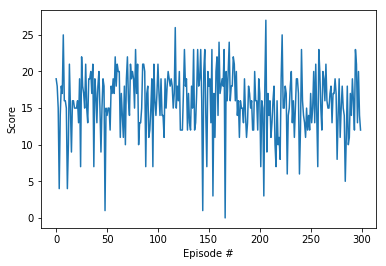

In [12]:
def eval_dqn_agent(n_episodes=300, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):          
        score = eval_agent(agent=agent,train_mode=True)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# evaluate the trained DQN agent
scores = eval_dqn_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()